## Probem Statement
Topik yang dikerjakan pada notebook dibawah ini adalah Natural Language Processing. Dataset yang digunakan merupakan data hasil scrapping dari website `https://femaledaily.com/` yaitu suatu website yang berisi review penggunaan produk skin care dan make up.  Produk yang dianalisis dalam hal ini adalah produk sunscreen dari salah satu brand lokal. Library yang digunakan untuk melakukan scrapping adalah BeautifulSoap dengan data yang di scrapping terdiri dari nama user, rentang usia, review produk dan rating produk. 

## Objective
- Memperoleh Insight terkait dengan review produk.
- Melakukan prediksi rating berdasarkan review dengan menggunakan Neural Network.

In [846]:
!python --version
import pandas as pd
print("\nPandas ver.:",pd.__version__)
import numpy as np
print("Numpy ver.:",np.__version__)

import matplotlib.pyplot as plt
import seaborn as sns

import re
import swifter

import nltk
print("NLTK ver.:",nltk.__version__)
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

import pickle

from nltk.probability import FreqDist
from nltk.corpus import stopwords

import sklearn
from sklearn.model_selection import train_test_split
print("SKlearn ver.:",sklearn.__version__)
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import tensorflow as tf
from tensorflow import keras
print("Tensorflow ver.:",tf.__version__)
print("Keras ver.:",keras.__version__)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from tensorflow.keras.layers import Input, LSTM, Dense, concatenate, Embedding, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1, l2


from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Python 3.9.5

Pandas ver.: 1.4.0
Numpy ver.: 1.19.5
NLTK ver.: 3.6.7
SKlearn ver.: 1.0.1
Tensorflow ver.: 2.7.0
Keras ver.: 2.7.0


# 1.Load Data

In [690]:
df = pd.read_csv("dataset/wardah-5500.csv")

In [691]:
df.sample(5)

,user_name,age_range,review,review_star,list_of_recommends
1046,Annisaherlynd,25 - 29,Ini sunscreen yg bikin aku BO.. awal pake waja...,2,Null
1787,Nadeaputri,19 - 24,Aku kurang suka dengan sunscreen ini. Setiap l...,3,No
924,rifasals,19 - 24,aku kebeli ini tu karena temen” aku bnyak yg p...,2,Null
5149,Kayla12,19 - 24,so far this is my favorite sunscreen. di kulit...,5,Null
5037,febtarinar,25 - 29,"Demen banget aku sama produk ini, sekarang2 ka...",5,Yes


# 2. Exploratory Data analysis

In [692]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_name           5500 non-null   object
 1   age_range           5500 non-null   object
 2   review              5500 non-null   object
 3   review_star         5500 non-null   int64 
 4   list_of_recommends  5500 non-null   object
dtypes: int64(1), object(4)
memory usage: 215.0+ KB


Dataset terdiri dari 5 kolom, pada permasalahan yang dikerjakan ini akan berfokus pada kolom `review` yang berisi informasi review yang diberikan pengguna dan kolom `review_star` yang memiliki informasi rating yang diberikan oleh pengguna dari skala 1-5. 

### Check Distribution of Rating

Text(0.5, 0, 'Rating')

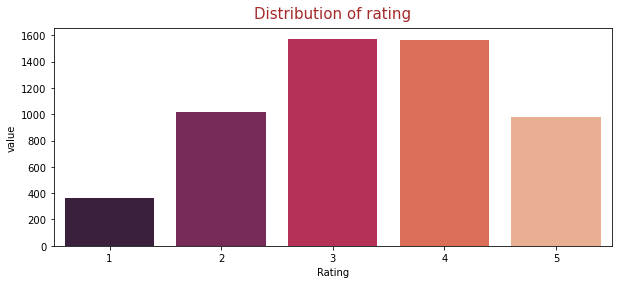

In [693]:
df_rating = df.groupby(['review_star']).size().reset_index()

plt.figure(figsize=(10,4))
sns.barplot(x ='review_star', y=0, data=df_rating, palette = 'rocket' )
plt.title('Distribution of rating',
         loc='center', pad=10, fontsize=15, color='brown')
plt.ylabel('value')
plt.xlabel('Rating')

- Sebagain besar pengguna memberikan rating 3 dan 4 terhadap produk.
- Persebaran rating 2 dan 5 cukup merata.
- Pengguna yang memberikan rating 1 cukup rendah yaitu 355 pengguna dari keseluruhan data, yang mana hal ini menyebabkan adanya imbalance antar data yang cukup signifikan. oleh karena itu, semua data dengan rating satu akan disatukan dengan data rating dua.

In [694]:
df['review_star'] = df['review_star'].replace([1],2)

### Check distribution after merge data 

Text(0.5, 0, 'Rating')

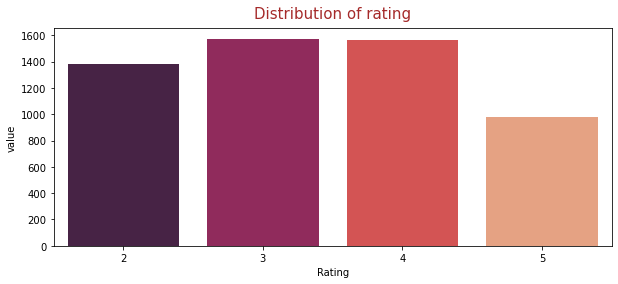

In [695]:
df_rating = df.groupby(['review_star']).size().reset_index()

plt.figure(figsize=(10,4))
sns.barplot(x ='review_star', y=0, data=df_rating, palette = 'rocket' )
plt.title('Distribution of rating',
         loc='center', pad=10, fontsize=15, color='brown')
plt.ylabel('value')
plt.xlabel('Rating')

Setelah dilakukan penggabungan data yang memiliki rating 1 dengan data yang memiliki rating 2 tampak bahwa data dengan rating dua tidak memiliki perbedaan yang cukup signifikan dengan data yang memiliki rating 3 dan 4.

### Check Distribution of Recommendation

Text(0.5, 0, 'Recommends')

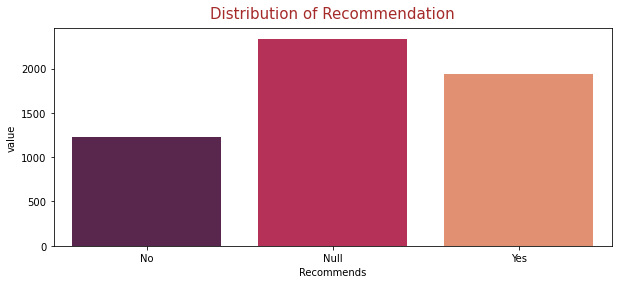

In [696]:
df_rating = df.groupby(['list_of_recommends']).size().reset_index()

plt.figure(figsize=(10,4))
sns.barplot(x ='list_of_recommends', y=0, data=df_rating, palette = 'rocket' )
plt.title('Distribution of Recommendation',
         loc='center', pad=10, fontsize=15, color='brown')
plt.ylabel('value')
plt.xlabel('Recommends')

Dari 5000 data yang digunakan ~3000 pengguna merekomendasikan produk sedangkan ~2000 pengguna tidak merekomendasikan produk sunscreen ini. Selanjutnya akan kita lihat bagaimana sebaran rekomendasi ini berdasarkan rating.

### Checking Frequency of Words and Phrases in Review

In [697]:
df_review = " ".join(df['review'].values)

reviews = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+') 
tokenized_reviews = tokenizer.tokenize(df_review)

for review in tokenized_reviews:
    reviews.append(review.lower())
    
stop_words = stopwords.words("indonesian")

flat_review_no_stop = [word for word in reviews if word not in stop_words]

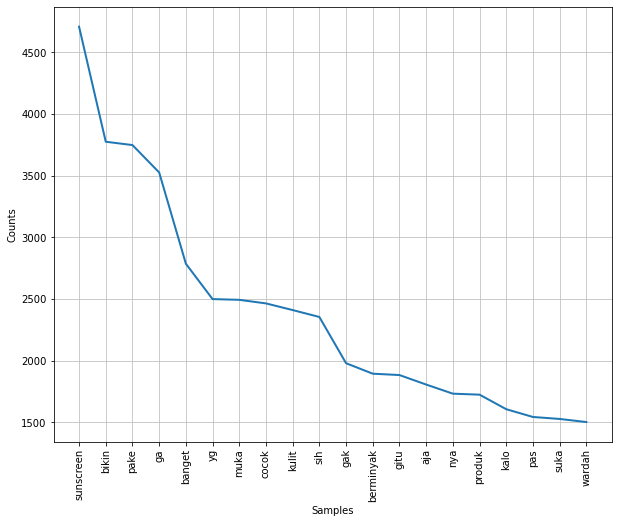

In [698]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
FreqDist(flat_review_no_stop).plot(20)
plt.show()

- Hasil grafik diatas menunjukkan kata sunscreen paling banyak muncul, hal ini sangat wajar karena pada dasarnya produk yang dilakukan analisis ini merupakan produk sunscreen. 
- Ditemukan beberapa kata yang menunjukkan konteks positif seperti cocok, suka. Selain itu terdapat beberapa kata yang menunjukkan konteks negatif seperti berminyak.
- Cukup banyak stopwords yang memiliki frekuensi penyebutan tinggi.

### Checking Frequency of Words with Removing Unmeaningful Words

Untuk selanjutnya dibawah ini dilakukan pengecekan frekuensi kata kembali dengan melakukan filter pada beberapa stowords.

In [699]:
for word in ['sunscreen','pake','ga','yg','sih','gak','gitu','aja','nya','kalo', 'bikin', 'banget','ya','bgt','wardah',
            'spf','trs','emg','yaa','klo','but','tpi','trs','wkwk','udh','deh','sampe','deh','gatau']:
    stop_words.append(word)
    
flat_review_no_stop_2 = [word for word in flat_review_no_stop if word not in stop_words]

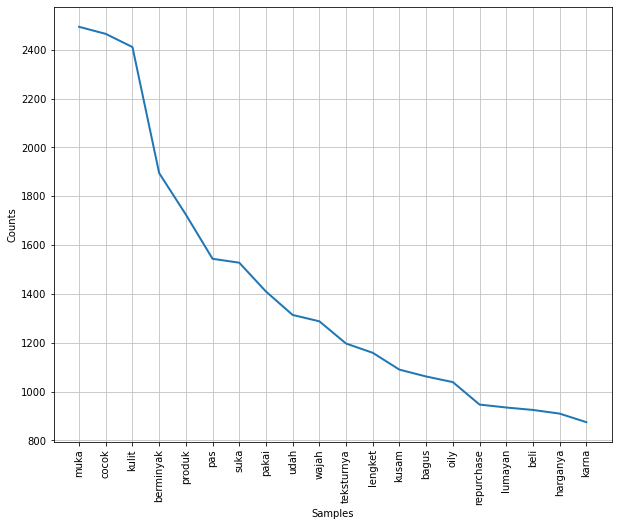

In [700]:
plt.figure(figsize=(10,8))
FreqDist(flat_review_no_stop_2).plot(20)
plt.show()

Setelah dilakukan filter stopword hasil plot frekuensi kemunculan kata tampak lebih spesifik. Seperti kata cocok yang mengindikasikan apakah pengguna sesuai atau tidak dengan produk. Kemudian juga terdapat kata-kata positif lain seperti suka, lumayan dan lainnya. Selain itu juga terdapat kata yang berkonotasi negatif seperti berminyak, oily, lengket.

### WordCloud for Review

In [701]:
flat_clean_sum_str = " ".join(flat_review_no_stop_2)

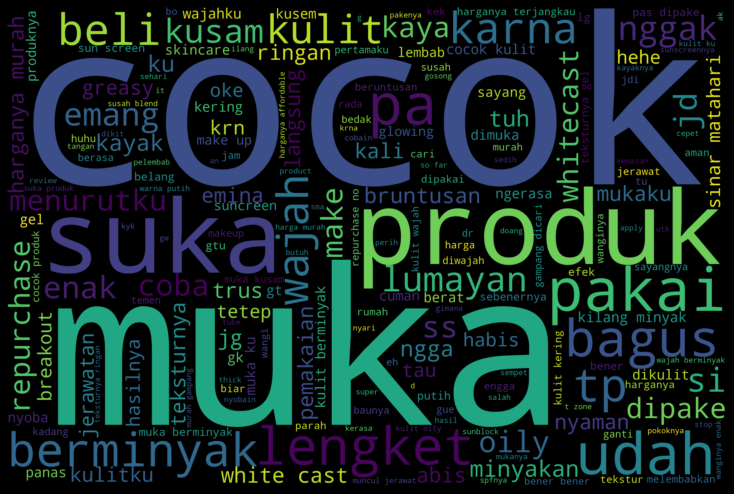

In [702]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      background_color = 'black',
                      stopwords = stop_words)

wordcloud.generate(flat_clean_sum_str)

plt.figure(figsize = (10,10),
           facecolor = 'k',
           edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Hasil diatas menunjukkan kata yang sering muncul baik yang berkonotasi negatif maupun yang berkonotasi positf, semakin besar ukuran font dari kata diatas maka mengindikasikan bahwa kata tersebut paling banyak muncul dalam review produk ini. Diantara kata yang paling banyak muncul berdasarkan wordcloud diatas adalah cocok, muka, kulit, bagus, minyakan dan lain sebagainya.

# 4. Data Cleaning and Pre-processing

### Remove Special Character

Pada tahapan dibawah ini akan dilakukan cleansing `Review` untuk menghapus emoticons, simbol, punctuation dan lain sebagainya. 

In [703]:
import re
def proc_feature(features):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', features)
    processed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    processed_feature = processed_feature.lower()  
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    processed_feature = regrex_pattern.sub(r'',processed_feature)
    processed_feature = re.sub(r'[^\x00-\x7F]+',' ', processed_feature)
    return(processed_feature)

In [704]:
# data cleansing based on Regex
df['review_clean'] = df.review.apply(lambda x : proc_feature(x))
df['review_clean'].head()

0    suka sama teskturnya bikin wajah jadi lembab b...
1    beli di toko official mereka di shop karena di...
2    untuk suscreen wardah yang dulu putih hijau ud...
3    sunscreen pertama yang aku coba plusnya ngebua...
4    menurutku ini sunscreen yang paling aku gak su...
Name: review_clean, dtype: object

### Stopword

Setelah data sudah cukup bersih selanjutnya dilakukan cleansing stopword. Stopword sendiri merupakan kata yang sering digunakan dalam suatu bahasa seperti dalam bahasa Indonesia kata tidak, dengan, kalau, enggak dan lain sebagainya. 

In [705]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

# get stopword from Sastrawi stopword
list_stopwords = StopWordRemoverFactory().get_stop_words()

# append additional stopword
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo', "ss", 'kalo', 'amp', 'biar', 'bikin', 'bilang',
                        'krn', 'nya', 'nih', 'sih', 'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 'sihh','cmiiw','w',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah', 'pake','yg','sih','gitu', 'pake','yg','gitu','huhuuuuu','we','gw','gue',
                       'aja','nya','kalo', 'bikin',  'banget','ya','bgt','wardah', 'spf','trs','emg','yaa','klo','but',
                       'tpi','trs','wkwk','wkwkwk','udh','deh','sampe','deh','gatau', 'aja','nya','kalo', 'bikin', 'banget'])


# convert list to dictionary
dictionary = ArrayDictionary(list_stopwords)
stopword = StopWordRemover(dictionary)

In [706]:
# Implementing Stopword
df['review_clean_sw'] = df.review_clean.swifter.apply(lambda x : stopword.remove(x))
sample_text = df.loc[1]['review_clean_sw']
print(sample_text)

Pandas Apply:   0%|          | 0/5500 [00:00<?, ?it/s]

beli toko official shop diskon penasaran ku wangi ganggu ku tekstur thick lengket wajah ku kilang minyak pas keringatan ngga sengaja ampun perih iritasi ku ngga coba ni 


### Stemming

Setelah handling stopword tahapan cleansing selanjutnya adalah stemming. Stemming merupakan proses mengubah suatu kata menjadi bentuk kata dasarnya. Proses stemming yang dilakukan disini menggunakan StemmerFactory yang merupakan bagian dari Sastrawi yaitu library NLP untuk bahasa Indonesia.

In [707]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [708]:
# Implementing Stemming
df['review_clean_sw'] = df.review_clean_sw.swifter.apply(lambda x : stemmer.stem(x))
sample_text = df.loc[5]['review_clean_sw']
print(sample_text)

Pandas Apply:   0%|          | 0/5500 [00:00<?, ?it/s]

make tahun kyk sunscreen gel warna putih tutup ijo jaman sma dlu cocok2 eh formula beda oren pas mbak2nya suncreen 30 kasih oren yaudh pkk enak2 aj kyk dingin tnpa sadar timbul bruntusan jerawat gede pegang sakit bntr lg bulan aj eh lama2 bruntusan nyebar muka jerawat gede2 nongol ampe rahang stop pkk produk dn alhamdulillah kempes jerawat bruntusan2 jg kering skrg mlh males nyari2 suncreen pindah day cream ber aj dl cari aman dl


### Splitting Data

Setelah data review dibersihkan selanjutnya dilakukan splitting data yang nantinya akan digunakan pada tahap pre-processing dan implementasi model. Splitting data disini menggunakan package train_test_split dari scikit learn dengan prosesntase test size 10% dari keseluruhan data.

In [732]:
df_clean = df.copy()
df_clean = df_clean[['review_clean','review_clean_sw','review_star']]

In [733]:
def convert_label(x):
    if x == 2:
        target = 0
    elif x == 3:
        target = 1
    elif x == 4:
        target = 2
    elif x == 5:
        target = 3
    return target

In [734]:
df_clean['review_star'] = df_clean.apply(lambda x: convert_label(x['review_star']), axis = 1)

In [735]:
X = df_clean['review_clean_sw']
y = df_clean['review_star']

In [736]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      random_state=42, 
                                                      test_size=0.1, 
                                                      stratify=y)

### Tokenization

##### Create Corpus

In [737]:
tokenizer = Tokenizer(num_words=3000, oov_token="<OOV>") 
tokenizer.fit_on_texts(X_train) 

word_index = tokenizer.word_index 
print('Found %s unique tokens.' % len(word_index))

Found 7942 unique tokens.


In [738]:
# save tokenizer into pickle for deployment
with open("save_tokenizer.pkl","wb") as filename:
    pickle.dump(tokenizer, filename)

Pre-processing pertama yang dilakukan setelah melakukan splitting data adalah membuat `Corpus` dengan memanfaatkan instance Tokenizer dari keras. Corpus disini berupa object yang memiliki key value berupa kata dan token berupa number yang merepresentasikan kata tersebut. Pada corpus perlu ditambahkan `<OOV>` untuk merepresentasikan kata yang tidak dikenali.

##### Text to Sequences

In [739]:
train_sequences = tokenizer.texts_to_sequences( X_train) 
test_sequences = tokenizer.texts_to_sequences(X_test) 

Pada tahap diatas dilakukan proses mengubah kalimat menjadi sequence of token dengan memanfaatkan method text_to_sequence.

##### Padding

In [740]:
MAX_SEQUENCE_LENGTH = 30

trainvalid_data = pad_sequences(train_sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

trainvalid_labels = to_categorical(np.asarray(y_train))
test_labels = to_categorical(np.asarray(y_test))

Tahap selanjutnya setelah mengubah sentence menjadi sequence of token adalah melakukan padding. Proses padding ini bertujuan agar setiap sequence of tokens memiliki ukuran yang sama, secara default ukuran padding akan menyesuaikan max length dari sequence of token namun disini kita akan mengatur ukuran maxlen 50.

##### Splitting train and validation data

In [741]:
indices = np.arange(trainvalid_data.shape[0])
np.random.shuffle(indices)

trainvalid_data = trainvalid_data[indices]
trainvalid_labels = trainvalid_labels[indices]
num_validation_samples = int(0.2 * trainvalid_data.shape[0])

X_train = trainvalid_data[:-num_validation_samples]
y_train = trainvalid_labels[:-num_validation_samples]

X_val = trainvalid_data[-num_validation_samples:]
y_val = trainvalid_labels[-num_validation_samples:]

print('Splitting the train data into train and valid is done')

Splitting the train data into train and valid is done


# 5. Model Implementation

In [742]:
# Function for Plot Model Evaluation
def plot_loss_curves(history):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(loss))
    
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss Curves')
    plt.legend()
    
    plt.subplot(1, 2,2 )
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    
    plt.show()
#     plt.savefig('{}.png'.format(accuracy_name))

In [743]:
vocab_size = 3000
embedding_dim = 64

## Base Model

In [744]:
base_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(4, activation="softmax")
])
base_model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

base_model.summary()


Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, None, 64)          192000    
                                                                 
 global_average_pooling1d_37  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_98 (Dense)            (None, 32)                2080      
                                                                 
 dense_99 (Dense)            (None, 4)                 132       
                                                                 
Total params: 194,212
Trainable params: 194,212
Non-trainable params: 0
_________________________________________________________________


- Layer pertama adalah embedding layer dengan 64 embedding dimensi. Layer embedding akan menyimpan satu vektor pada setiap kata. Setelah dilakukan training, kata-kata dengan makna yang serupa seringkali memiliki vektor yang bersesuain.
- Layer kedua adalah global average pooling.
- Layer ketiga adalah dense layer dengan jumlah node 32 dengan activation function relu.
- Layer terakhir memiliki 5 node dengan activation function softmax karena merupakan multiclass classification.

Pada proses dibawah ini dilakukan fit model dengan jumlah epochs 30 dengan batch size 60.

In [745]:
num_epochs = 20
# Set callback to store model with best validation accuracy during training.
bm = ModelCheckpoint("model/base_model.h5", save_best_only=True)

history_bm = base_model.fit(
                    X_train, y_train, 
                    validation_data = (X_val, y_val), 
                    batch_size=60, 
                    epochs=num_epochs,
                    callbacks=[bm])

Epoch 1/20
66/66 [==============================] - 1s 10ms/step - loss: 1.3656 - accuracy: 0.3194 - val_loss: 1.3491 - val_accuracy: 0.3505
Epoch 2/20
66/66 [==============================] - 0s 6ms/step - loss: 1.2986 - accuracy: 0.4270 - val_loss: 1.2642 - val_accuracy: 0.4404
Epoch 3/20
66/66 [==============================] - 0s 5ms/step - loss: 1.1586 - accuracy: 0.4914 - val_loss: 1.1661 - val_accuracy: 0.4394
Epoch 4/20
66/66 [==============================] - 0s 5ms/step - loss: 1.0327 - accuracy: 0.5288 - val_loss: 1.1237 - val_accuracy: 0.4657
Epoch 5/20
66/66 [==============================] - 0s 5ms/step - loss: 0.9397 - accuracy: 0.5907 - val_loss: 1.1254 - val_accuracy: 0.4636
Epoch 6/20
66/66 [==============================] - 0s 6ms/step - loss: 0.8604 - accuracy: 0.6530 - val_loss: 1.1413 - val_accuracy: 0.4566
Epoch 7/20
66/66 [==============================] - 0s 5ms/step - loss: 0.7931 - accuracy: 0.6896 - val_loss: 1.1718 - val_accuracy: 0.4566
Epoch 8/20
66/66 [=

In [781]:
base_model = keras.models.load_model("model/base_model.h5") # rollback to best model

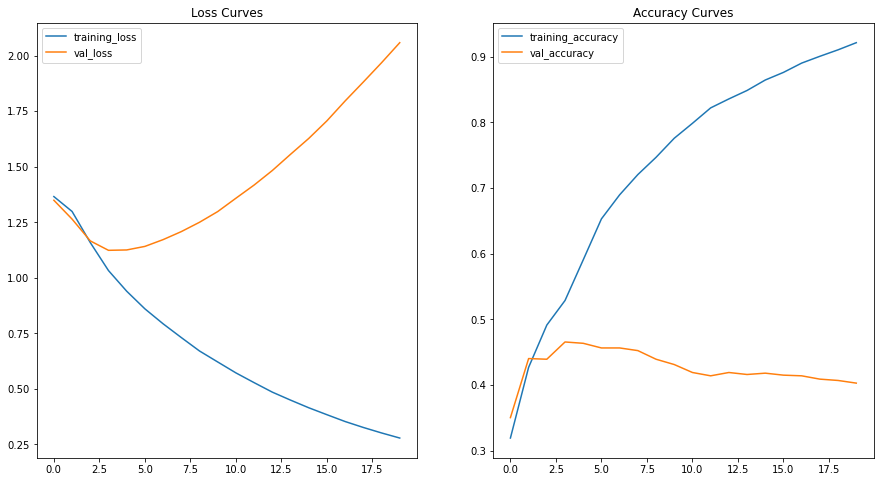

In [746]:
plot_loss_curves(history_bm)

Hasil komparasi plot antara data train dan data validation diatas menghasilkan beberapa kesimpulan
- Pada grafik loss tampak adanya overfitting yang sangat signifikan antara loss data train dan data val, hasil dari history fit model menunjukkan nilai loss pada epoch pertama berada pada kisaran `1.5` kemudian pada data validation mengalami penurunan hingga epoch ke-6 namun mulai mengalami kenaikan loss pada epoch ke-7 hingga epoch terakhir. Sedangkan pada data train nilai loss cenderung mengalami penurunan secara konstan.
- Pada grafik accuracy pada epoch pertama accuracy dari data train dan data val berada pada kisaran 0.36. Pada data train terjadi kenaikan yang cukup signifikan hingga diperoleh nilai accuracy tertinggi mendekati 1, namun sebaliknya pada data val nilai accuracy yang awalnya meningkat pada epoch ke-10 mulai mengalami penurunan dan cenderung konstan berada diangka 0.44. Perbedaan yang signifikan antara nilai accuracy dari data train dan data test menunjukkan adanya overfitting pada matrics accuracy.
- Untuk selanjutnya pada tahap improvement model akan ditambahkan dropout dan regularitation dengan harapan agar mengurangi overfitting.

In [782]:
base_model.evaluate(test_data, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1.1245 - accuracy: 0.4764


[1.124531626701355, 0.4763636291027069]

In [783]:
y_pred = base_model.predict(test_data)
print(f"Classification Report:\n{classification_report(test_labels.argmax(axis=1), y_pred.argmax(axis=1))}\n")

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.62       138
           1       0.42      0.39      0.40       157
           2       0.42      0.71      0.53       157
           3       0.62      0.05      0.09        98

    accuracy                           0.48       550
   macro avg       0.53      0.44      0.41       550
weighted avg       0.51      0.48      0.44       550




- Hasil evaluasi dari base model dengan menggunakan data test diperoleh nilai loss `1.12453` sedangkan nilai accuracy `0.48`

### Model LSTM

In [754]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.LSTM(64),
     tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()


Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_53 (Embedding)    (None, None, 64)          192000    
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dense_106 (Dense)           (None, 32)                2080      
                                                                 
 dense_107 (Dense)           (None, 4)                 132       
                                                                 
Total params: 227,236
Trainable params: 227,236
Non-trainable params: 0
_________________________________________________________________


- Layer pertama adalah embedding layer dengan embedding dimensi 64. Layer embedding akan menyimpan satu vektor pada setiap kata. Setelah dilakukan training, kata-kata dengan makna yang serupa seringkali memiliki vektor yang bersesuain.
- Layer kedua adalah lstm layer.
- Layer ketiga adalah dense layer dengan jumlah node 32 dengan activation function relu.
- Layer terakhir memiliki 4 node dengan activation function softmax karena merupakan multiclass classification.

Pada proses dibawah ini dilakukan fit model dengan jumlah epochs 10 dengan batch size 32.

In [755]:
num_epochs = 10
# Set callback to store model with best validation accuracy during training.
lstm = ModelCheckpoint("model/lstm_model.h5", save_best_only=True)
history_lstm = model_lstm.fit(X_train, y_train, 
                    validation_data = (X_val, y_val), 
                    batch_size=32, 
                    epochs=num_epochs,
                    callbacks=[lstm]
                   )

Epoch 1/10
124/124 [==============================] - 6s 32ms/step - loss: 1.3314 - accuracy: 0.3303 - val_loss: 1.2070 - val_accuracy: 0.4051
Epoch 2/10
124/124 [==============================] - 3s 28ms/step - loss: 1.1263 - accuracy: 0.4518 - val_loss: 1.1573 - val_accuracy: 0.4424
Epoch 3/10
124/124 [==============================] - 4s 30ms/step - loss: 1.0040 - accuracy: 0.5263 - val_loss: 1.1752 - val_accuracy: 0.4293
Epoch 4/10
124/124 [==============================] - 4s 32ms/step - loss: 0.8922 - accuracy: 0.6035 - val_loss: 1.2284 - val_accuracy: 0.4343
Epoch 5/10
124/124 [==============================] - 3s 24ms/step - loss: 0.7770 - accuracy: 0.6753 - val_loss: 1.3228 - val_accuracy: 0.4253
Epoch 6/10
124/124 [==============================] - 4s 30ms/step - loss: 0.6735 - accuracy: 0.7308 - val_loss: 1.4387 - val_accuracy: 0.4242
Epoch 7/10
124/124 [==============================] - 3s 27ms/step - loss: 0.5942 - accuracy: 0.7657 - val_loss: 1.7454 - val_accuracy: 0.4192

In [784]:
model_lstm = keras.models.load_model("model/lstm_model.h5") # rollback to best model

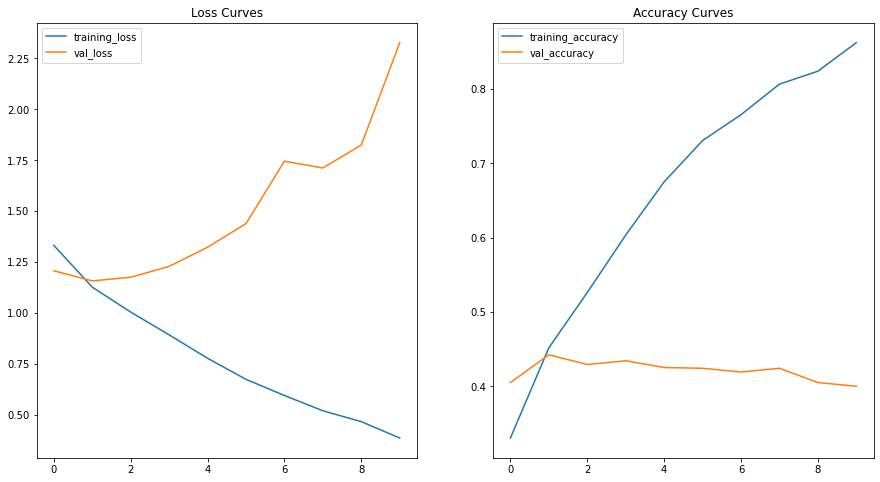

In [756]:
plot_loss_curves(history_lstm)

Berdasarkan grafik diatas hasil perbanding loss dan accuracy pada data train dan data test tidak berbeda jauh dengan hasil evaluasi dari base model yaitu terjadi overfitting. Hasil loss dari validation data menunjukkan tidak adanya penurunan, sedangkan matrics accuracy dari data validation stagnan dikisaran angka 0.4.

In [785]:
model_lstm.evaluate(test_data, test_labels)

18/18 [==============================] - 1s 9ms/step - loss: 1.1633 - accuracy: 0.4436


[1.1633009910583496, 0.44363635778427124]

In [786]:
y_pred = model_lstm.predict(test_data)
print(f"Classification Report:\n{classification_report(test_labels.argmax(axis=1), y_pred.argmax(axis=1))}\n")

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.77      0.63       138
           1       0.37      0.18      0.24       157
           2       0.39      0.70      0.50       157
           3       0.00      0.00      0.00        98

    accuracy                           0.44       550
   macro avg       0.33      0.41      0.35       550
weighted avg       0.35      0.44      0.37       550




- Hasil evaluasi dari model LSTM dengan menggunakan data test diperoleh nilai loss `2.15183` sedangkan nilai accuracy `0.44`. 

### Model Bi-directional LSTM

In [771]:
model_bilstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_58 (Embedding)    (None, None, 64)          192000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_116 (Dense)           (None, 64)                8256      
                                                                 
 dense_117 (Dense)           (None, 4)                 260       
                                                                 
Total params: 266,564
Trainable params: 266,564
Non-trainable params: 0
_________________________________________________________________


- Layer pertama adalah embedding layer dengan embedding dimensi 64 dan vocab size 3000. Layer embedding akan menyimpan satu vektor pada setiap kata. Setelah dilakukan training, kata-kata dengan makna yang serupa seringkali memiliki vektor yang bersesuain.
- Layer kedua adalah bidirectional lstm layer dengan parameter 32.
- Layer ketiga adalah dense layer dengan jumlah node 32 dengan activation function relu.
- Layer terakhir memiliki 4 node dengan activation function softmax karena merupakan multiclass classification.
- Optimer yang digunakan pada model adalah adam optimizer.

Pada proses dibawah ini dilakukan fit model dengan jumlah epochs 10 dengan batch size 32.

In [768]:
num_epochs = 10
# Set callback to store model with best validation accuracy during training.
bi_lstm = ModelCheckpoint("model/bi_lstm_model.h5", save_best_only=True)
history_bi_lstm = model_bilstm.fit(X_train, y_train, 
                    validation_data = (X_val, y_val), 
                    batch_size=32, 
                    epochs=num_epochs,
                    callbacks=[bi_lstm]
                   )

Epoch 1/10
124/124 [==============================] - 11s 46ms/step - loss: 1.2968 - accuracy: 0.3495 - val_loss: 1.1846 - val_accuracy: 0.4131
Epoch 2/10
124/124 [==============================] - 5s 40ms/step - loss: 1.0899 - accuracy: 0.4687 - val_loss: 1.1460 - val_accuracy: 0.4323
Epoch 3/10
124/124 [==============================] - 5s 38ms/step - loss: 0.9383 - accuracy: 0.5806 - val_loss: 1.1878 - val_accuracy: 0.4313
Epoch 4/10
124/124 [==============================] - 5s 38ms/step - loss: 0.8085 - accuracy: 0.6543 - val_loss: 1.3004 - val_accuracy: 0.4384
Epoch 5/10
124/124 [==============================] - 5s 38ms/step - loss: 0.6862 - accuracy: 0.7179 - val_loss: 1.4898 - val_accuracy: 0.4202
Epoch 6/10
124/124 [==============================] - 5s 39ms/step - loss: 0.5672 - accuracy: 0.7793 - val_loss: 1.5733 - val_accuracy: 0.4313
Epoch 7/10
124/124 [==============================] - 5s 38ms/step - loss: 0.4474 - accuracy: 0.8293 - val_loss: 1.8720 - val_accuracy: 0.408

In [790]:
model_bilstm = keras.models.load_model("model/bi_lstm_model.h5") # rollback to best model

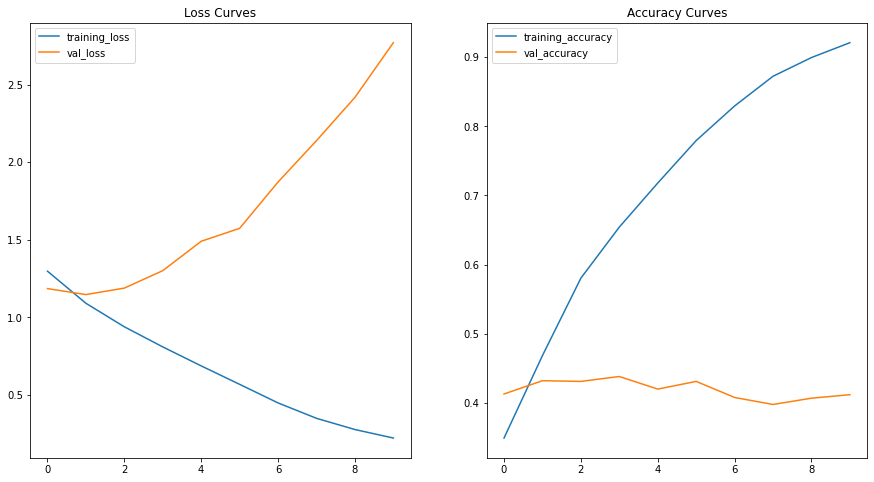

In [772]:
plot_loss_curves(history_bi_lstm)

Hasil komparasi plot antara data train dan data validation diatas menghasilkan beberapa kesimpulan
- Pada grafik loss tampak adanya overfitting yang sangat signifikan antara loss data train dan data val, hasil dari history fit model menunjukkan nilai loss pada epoch pertama berada pada kisaran `1.1846` namun hingga epoch terakhir yaitu pada epoch ke-10 nilai loss validasi mengalami kenaikan hingga mencapai `2.7`. Sedangkan pada data train nilai loss cenderung mengalami penurunan yang signifikan. Perbedaan nilai yang cukup jauh antara loss data train dan data val menyebabkan terjadinya overfitting.
- Pada grafik accuracy hasil yang diperoleh tidak jauh berbeda dengan dua model sebelumnya yaitu terjadi overfitting.
- Untuk selanjutnya pada tahap improvement model akan ditambahkan dropout dan regularitation dengan harapan agar mengurangi overfitting.

In [788]:
model_bilstm.evaluate(test_data, test_labels)

18/18 [==============================] - 1s 16ms/step - loss: 1.1433 - accuracy: 0.4418


[1.1433215141296387, 0.4418181777000427]

In [789]:
y_pred = model_bilstm.predict(test_data)
print(f"Classification Report:\n{classification_report(test_labels.argmax(axis=1), y_pred.argmax(axis=1))}\n")

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.43      0.52       138
           1       0.37      0.41      0.39       157
           2       0.40      0.56      0.47       157
           3       0.45      0.31      0.37        98

    accuracy                           0.44       550
   macro avg       0.47      0.43      0.44       550
weighted avg       0.47      0.44      0.44       550




- Hasil evaluasi dari model bi-directional LSTM dengan menggunakan data test diperoleh nilai loss `1.143321` sedangkan nilai accuracy `0.44`. 

# 7. Model Improvement

Pada tahap improvement model ini akan dilakukan penambahan 2 layer dropout dan 1 dense layer pada setiap model yang telah digunakan diatas. Penambahan dropout bertujuan agar dapat mengurangi overfitting karena pada setiap model yang telah diimplementasikan diatas ditemukan adanya overfitting.

### Base Model with Dropout

In [775]:
base_model_imp = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(4, activation="softmax")
])
base_model_imp.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

base_model_imp.summary()


Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_60 (Embedding)    (None, None, 64)          192000    
                                                                 
 global_average_pooling1d_40  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_121 (Dense)           (None, 32)                2080      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_122 (Dense)           (None, 16)                528       
                                                     

Pada base model ini ditambahkan dua dropout dengan masing-masing nilai parameter `0.3` dan `0.2`. Selain itu, juga ditambahkan satu layer.

In [776]:
num_epochs = 20
# Set callback to store model with best validation accuracy during training.
bm_imp = ModelCheckpoint("model/base_model_imp.h5", save_best_only=True)

history_bm_imp = base_model_imp.fit(X_train, y_train, 
                    validation_data = (X_val, y_val), 
                    batch_size=32, 
                    epochs=num_epochs,
                    callbacks=[bm_imp])

Epoch 1/20
124/124 [==============================] - 2s 7ms/step - loss: 1.3754 - accuracy: 0.2889 - val_loss: 1.3568 - val_accuracy: 0.3364
Epoch 2/20
124/124 [==============================] - 1s 5ms/step - loss: 1.2723 - accuracy: 0.4081 - val_loss: 1.1743 - val_accuracy: 0.4404
Epoch 3/20
124/124 [==============================] - 1s 4ms/step - loss: 1.0875 - accuracy: 0.4869 - val_loss: 1.1240 - val_accuracy: 0.4586
Epoch 4/20
124/124 [==============================] - 1s 5ms/step - loss: 0.9896 - accuracy: 0.5442 - val_loss: 1.1222 - val_accuracy: 0.4747
Epoch 5/20
124/124 [==============================] - 1s 4ms/step - loss: 0.9033 - accuracy: 0.5960 - val_loss: 1.1552 - val_accuracy: 0.4707
Epoch 6/20
124/124 [==============================] - 1s 4ms/step - loss: 0.8417 - accuracy: 0.6399 - val_loss: 1.2152 - val_accuracy: 0.4586
Epoch 7/20
124/124 [==============================] - 1s 4ms/step - loss: 0.7738 - accuracy: 0.6753 - val_loss: 1.2620 - val_accuracy: 0.4545
Epoch 

In [791]:
base_model_imp = keras.models.load_model("model/base_model_imp.h5") # rollback to best model

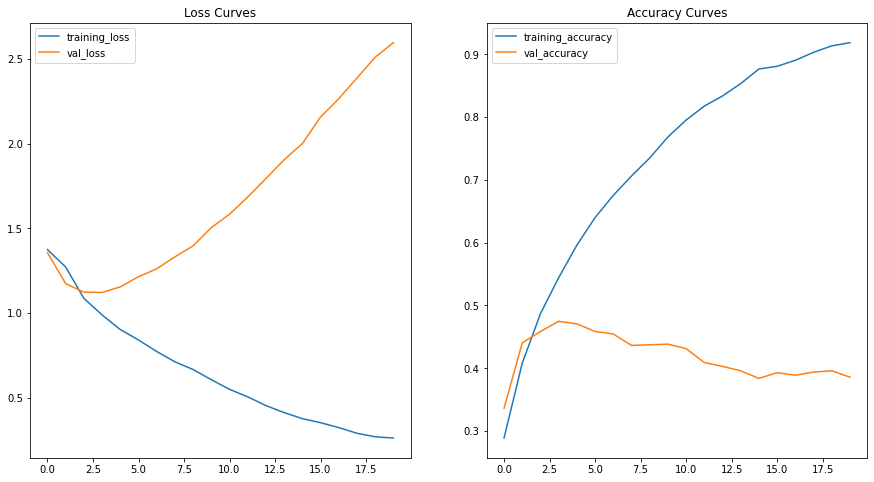

In [777]:
plot_loss_curves(history_bm_imp)

Setelah melakukan penambahan dropout pada model, tampak tidak adanya perbedaan signifikan dari sebelum ditambahkan dropout. Terlihat masih terjadi overfitting baik pada evaluasi loss maupun accuracy. Namun untuk melihat secara detail hasil komparasinya akan kita lihat berdasarkan dari hasil fit model terhadap data test.

In [792]:
base_model_imp.evaluate(test_data, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1.1556 - accuracy: 0.4600


[1.155643343925476, 0.46000000834465027]

In [794]:
y_pred = base_model_imp.predict(test_data)
print(f"Classification Report:\n{classification_report(test_labels.argmax(axis=1), y_pred.argmax(axis=1))}\n")

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.57      0.57       138
           1       0.38      0.45      0.41       157
           2       0.44      0.60      0.51       157
           3       0.52      0.11      0.18        98

    accuracy                           0.46       550
   macro avg       0.48      0.43      0.42       550
weighted avg       0.48      0.46      0.44       550




- Hasil evaluasi dari base model yang telah ditambahkan dropout diperoleh nilai loss `1.155` dan accuracy `0.66`. Hasil tersebut jika kita bandingkan dengan base model tanpa ada dropout sedikit lebih rendah, yang mana base model tanpa dropout memiliki nilai loss `1.12453` dan nilai accuracy `0.48`.

### LSTM model with Dropout

In [798]:
model_lstm_imp = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_lstm_imp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_imp.summary()


Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_62 (Embedding)    (None, None, 64)          192000    
                                                                 
 lstm_22 (LSTM)              (None, 64)                33024     
                                                                 
 dense_127 (Dense)           (None, 32)                2080      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_128 (Dense)           (None, 16)                528       
                                                                 
 dense_129 (Dense)           (None, 4)                 68        
                                                                 
Total params: 227,700
Trainable params: 227,700
Non-t

In [799]:
num_epochs = 10
# Set callback to store model with best validation accuracy during training.
lstm_imp = ModelCheckpoint("model/lstm_model_imp.h5", save_best_only=True)
history_lstm_imp = model_lstm_imp.fit(X_train, y_train, 
                    validation_data = (X_val, y_val), 
                    batch_size=32, 
                    epochs=num_epochs,
                    callbacks=[lstm_imp]
                   )

Epoch 1/10
124/124 [==============================] - 9s 51ms/step - loss: 1.3482 - accuracy: 0.3126 - val_loss: 1.2478 - val_accuracy: 0.3879
Epoch 2/10
124/124 [==============================] - 6s 48ms/step - loss: 1.1656 - accuracy: 0.4399 - val_loss: 1.1710 - val_accuracy: 0.4475
Epoch 3/10
124/124 [==============================] - 7s 53ms/step - loss: 1.0540 - accuracy: 0.4899 - val_loss: 1.1466 - val_accuracy: 0.4293
Epoch 4/10
124/124 [==============================] - 7s 54ms/step - loss: 0.9987 - accuracy: 0.5227 - val_loss: 1.1724 - val_accuracy: 0.4364
Epoch 5/10
124/124 [==============================] - 6s 48ms/step - loss: 0.9295 - accuracy: 0.5745 - val_loss: 1.2298 - val_accuracy: 0.4263
Epoch 6/10
124/124 [==============================] - 6s 47ms/step - loss: 0.8425 - accuracy: 0.6343 - val_loss: 1.3164 - val_accuracy: 0.4071
Epoch 7/10
124/124 [==============================] - 6s 47ms/step - loss: 0.7791 - accuracy: 0.6720 - val_loss: 1.3586 - val_accuracy: 0.4263

In [800]:
lstm_model_imp = keras.models.load_model("model/lstm_model_imp.h5") # rollback to best model

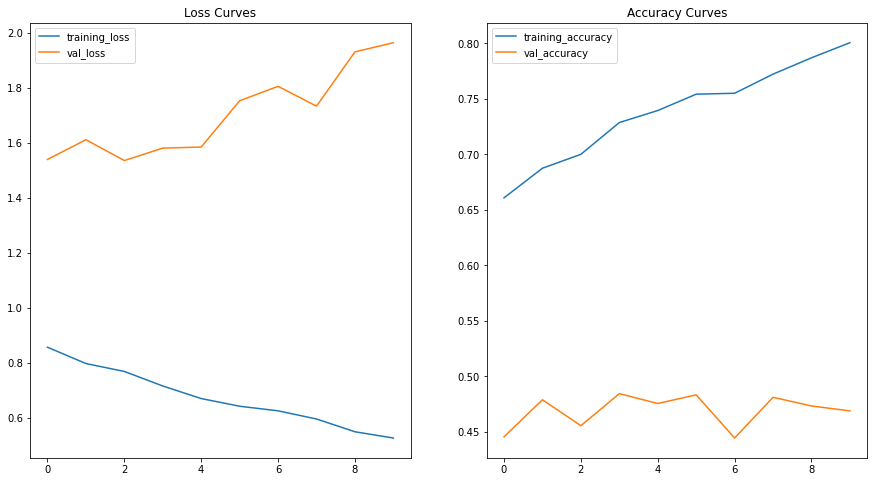

In [801]:
plot_loss_curves(history_lstm_imp_imp)

In [802]:
lstm_model_imp.evaluate(test_data, test_labels)

18/18 [==============================] - 1s 9ms/step - loss: 1.1706 - accuracy: 0.4327


[1.1705946922302246, 0.43272727727890015]

In [803]:
y_pred = lstm_model_imp.predict(test_data)
print(f"Classification Report:\n{classification_report(test_labels.argmax(axis=1), y_pred.argmax(axis=1))}\n")

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.43      0.51       138
           1       0.34      0.41      0.38       157
           2       0.43      0.72      0.54       157
           3       0.00      0.00      0.00        98

    accuracy                           0.43       550
   macro avg       0.35      0.39      0.36       550
weighted avg       0.37      0.43      0.39       550




Hasil evaluasi dari model LSTM dengan menggunakan data test diperoleh nilai loss `1.1705946` dan nilai accuracy `0.43`. Nilai loss yang diperoleh pada model LSTM degan penerapan dropout lebih baik daripada tanpa dropout yaitu `2.15183` ketika tanpa menggunakan dropout. Sedangkan nilai accuracy yang diperoleh sedikit lebih rendah jika dibandingkan tanpa dropout yaitu `0.44`.

### Bi-directional LSTM model with Dropout

In [824]:
model_bilstm_imp = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
     tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(4, activation='softmax')
])

model_bilstm_imp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm_imp.summary()

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_64 (Embedding)    (None, None, 64)          192000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_132 (Dense)           (None, 32)                4128      
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_133 (Dense)           (None, 4)                 132       
                                                                 
Total params: 262,308
Trainable params: 262,308
Non-trainable params: 0
_______________________________________________

In [830]:
num_epochs = 10
# Set callback to store model with best validation accuracy during training.
bilstm_imp = ModelCheckpoint("model/bilstm_model_imp.h5", save_best_only=True)
history_bi_lstm_imp = model_bilstm_imp.fit(X_train, y_train, 
                    validation_data = (X_val, y_val), 
                    batch_size=32, 
                    epochs=num_epochs,
                    callbacks=[bilstm_imp]
                   )

Epoch 1/10
124/124 [==============================] - 11s 85ms/step - loss: 0.3605 - accuracy: 0.8682 - val_loss: 2.1719 - val_accuracy: 0.4101
Epoch 2/10
124/124 [==============================] - 11s 87ms/step - loss: 0.3146 - accuracy: 0.8874 - val_loss: 2.5671 - val_accuracy: 0.4040
Epoch 3/10
124/124 [==============================] - 11s 89ms/step - loss: 0.2642 - accuracy: 0.9078 - val_loss: 3.0044 - val_accuracy: 0.4111
Epoch 4/10
124/124 [==============================] - 11s 86ms/step - loss: 0.2468 - accuracy: 0.9162 - val_loss: 2.8492 - val_accuracy: 0.3909
Epoch 5/10
124/124 [==============================] - 11s 87ms/step - loss: 0.2384 - accuracy: 0.9174 - val_loss: 2.8316 - val_accuracy: 0.4010
Epoch 6/10
124/124 [==============================] - 11s 88ms/step - loss: 0.2040 - accuracy: 0.9301 - val_loss: 3.0562 - val_accuracy: 0.4030
Epoch 7/10
124/124 [==============================] - 10s 78ms/step - loss: 0.1911 - accuracy: 0.9351 - val_loss: 3.4310 - val_accuracy:

In [832]:
y_pred = model_bilstm_imp.predict(test_data)
print(f"Classification Report:\n{classification_report(test_labels.argmax(axis=1), y_pred.argmax(axis=1))}\n")

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.44      0.46       138
           1       0.32      0.32      0.32       157
           2       0.41      0.47      0.44       157
           3       0.42      0.36      0.38        98

    accuracy                           0.40       550
   macro avg       0.40      0.40      0.40       550
weighted avg       0.40      0.40      0.40       550




### Comparation model evaluation

#### Model without dropout

In [778]:
# base model 
base_model.evaluate(test_data, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 2.0067 - accuracy: 0.4127


[2.006743907928467, 0.4127272665500641]

In [779]:
# LSTM model 
model_lstm.evaluate(test_data, test_labels)

18/18 [==============================] - 1s 13ms/step - loss: 2.1518 - accuracy: 0.4236


[2.1518301963806152, 0.42363637685775757]

In [780]:
# Bi-directional LSTM model 
model_bilstm.evaluate(test_data, test_labels)

18/18 [==============================] - 2s 11ms/step - loss: 1.3874 - accuracy: 0.1927


[1.3873895406723022, 0.19272726774215698]

#### Model with Dropout

In [805]:
# base Model
base_model_imp.evaluate(test_data, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1.1556 - accuracy: 0.4600


[1.155643343925476, 0.46000000834465027]

In [804]:
# LSTM Model
lstm_model_imp.evaluate(test_data, test_labels)

18/18 [==============================] - 0s 8ms/step - loss: 1.1706 - accuracy: 0.4327


[1.1705946922302246, 0.43272727727890015]

In [845]:
# LSTM Model
bi_lstm_model_imp.evaluate(test_data, test_labels)

18/18 [==============================] - 1s 13ms/step - loss: 2.0537 - accuracy: 0.3873


[2.0536773204803467, 0.3872727155685425]

Berdasarkan perbandingan keseluruhan model diatas diperoleh hasil terbaik diperoleh pada base model yang telah dilakukan improvement dengan penambahan dropout. Begitupun accuracy terbaik terdapat pada model tersebut.

# 8. Model Inference

In [839]:
new_review1 = "sayang bangettt "

In [843]:
review_tokenize = save_tokenizer.texts_to_sequences([new_review1])
review_text_pad = pad_sequences(review_tokenize, padding='post',maxlen=50)

prediction = base_model_imp.predict(review_text_pad)
print(prediction)
prediction = np.argmax(prediction) + 2


[[0.35155582 0.42048526 0.17761685 0.05034199]]


In [844]:
print("Kustomer dengan review diatas di prediksi memberi rating",prediction)

Kustomer dengan review diatas di prediksi memberi rating 3


# 9. Analysis

### Insight Analysis

Beberapa insight yang diperoleh dari data adalah
- Dataset yang digunakan terdiri dari 5500 data review dan rating .
- Rating produk berada pada rentang 1-5 dengan rating terbanyak adalah bintang 3 dan 4, sedangkan jumlah rating paling sedikit adalah bintang 1 dengan jumlah 375.
- Hasil dari wordcloud menunjukkan kata yang paling banyak muncul adalah cocok, muka, kulit, bagus, minyakan, suka, melembabka dan lain sebagainya. Diantara kata-kata tersebut ada yang memiliki makna positif dan juga negatif.
- Pada data review sebelum dilakukan cleansing banyak ditemukan emoticon, punctuation, singkatan, whitespace, kata yang huruf akhirnya ditulis berkali kali seperti `bangetttt` dan lain sebagainya.
- Pada tahap cleansing data review selain membuat custom function untuk menghapus puntuation, uppercase, emotin dan lain-lainnya, juga dilakukan stemming dan stopword menggunakan library sastrawi yang diperuntukkan untuk handling stopword dan stemming pada NLP bahasa Indonesia. Namun meskipun stopword dan stemming telah dilakukan masih banyak ditemukan slang, pengulangan kata, pencampuran kalimat dengan bahasa inggris dan lain-lain.

### Model Analysis
- Sebelum ke tahap modelling data yang telah di split di terapkan tokenization, padding, dan one hot encoding pada label terlebih dahulu.
- Pada tahap implementasi model diterapkan tiga model yaitu base model, LSTM model dan bidirectional LSTM model. Selain itu, juga dilakukan model improvement dengan menambahkan dropout karena ditemukan overfitting pada keseluruhan model.
- Hasil dari base model
    - Sebelum ditambahkan dropout grafik perdandingan evaluasi dan accuracy antara data train dan data evaluation menunjukkan adanya overfitting. 
    - Hasil evaluasi terhadap data test pada base model tanpa dropout adalah `2.006` untuk nilai loss dan `0.41272` untuk accuracy.
    - Setelah ditambahkan dropout grafik evaluasi masih menunjukkan adanya overfitting, namun terjadi sedikit perbaikian pada loss dan accuracy data test yaitu `0.46` untuk nilai accuracy yang berarti terjadi kenaikan sekitar 0.05 dan penurunan loss menjadi `1.155`.
- Hasil dari LSTM model
    - Sebelum ditambahkan dropout grafik perdandingan evaluasi dan accuracy antara data train dan data evaluation menunjukkan adanya overfitting. 
    - Hasil evaluasi terhadap data test pada base model tanpa dropout adalah `2.151` untuk nilai loss dan `0.4236` untuk accuracy.
    - Setelah ditambahkan dropout grafik evaluasi masih menunjukkan adanya overfitting, namun terjadi sedikit perbaikian pada loss dan accuracy data test yaitu `0.4327` untuk nilai accuracy dan penurunan loss menjadi `1.1705`.
- Hasil dari Bi-directional LSTM model
    - Sebelum ditambahkan dropout grafik perdandingan evaluasi dan accuracy antara data train dan data evaluation menunjukkan adanya overfitting. 
    - Hasil evaluasi terhadap data test pada base model tanpa dropout adalah `1.3873` untuk nilai loss dan `0.192` untuk accuracy nilai ini menjadi yang terendah jika dibandingkan dengan evaluasi accuracy pada model lainnya.
    - Setelah ditambahkan dropout grafik evaluasi masih menunjukkan adanya overfitting, namun terjadi sedikit perbaikian pada accuracy data test yaitu `0.387`. Sedangkan nilai loss menjadi `2.0536`, yang berarti tidak lebih baik dari sebelum tanpa dropout.
- Secara keseluruhan model dengan loss dan accuracy terbaik adalah base model setelah ditambahkan dropout.

### Hypotesis analisis
Pada keseluruhan model yang digunakan hasil evaluasi maupun loss yang diperoleh mengalami overfitting yang sangat signifikan antara data train dan data validation, selain itu nilai matrics evaluasi yang diperoleh juga kurang bagus yaitu berada pada kisaran `0.4`.Beberapa kemungkinan yang menyebabkan hal tersebut adalah:
- Dataset yang digunakan terlalu sedikit yaitu hanya 5500 data, sehingga ketika diterapkan model dengan layer yang agak kompleks akan menyebabkan hasil yang diperoleh kurang bagus.
- Terdapat imbalance pada label meskipun telah dilakukan penggabungan data antara rating 1 yang jumlahnya paling sedikit dengan rating 2. Imbalance lain terdapat pada rating 5 yang jumlah datanya hanya berkisar `900` data sedangkan pada label lainnya yaitu 2,3 dan 4 berada pada kisaran `1500` data.
- Problem NLP yang dianalisis disini berbahasa Indonesia, sedangkan library untuk handling stopword dan stamming pada bahasa Indonesia masih terbatas. Salah satu solusinya adalah membuat dictionary sendiri sesuai problem yang diangkat.
- Penggunaan parameter maupun ketika menginisialisasi suatu value kemungkinan masih belum tepat guna. Sehingga hasil yang diperoleh juga tidak sesuai yang diharapkan. 